<div align="center">
<h3> CS 178: Machine Learning & Data Mining </h3>
<h2> An Investigation of Classification Methods for Diabetes 130-US Hospitals </h2>
</div>

In [272]:
import numpy as np
import pandas as pd

from typing import List, Tuple
import matplotlib.pyplot as plt
import math

from sklearn.datasets import fetch_openml
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.preprocessing import StandardScaler

seed=1234
np.random.seed(seed)

# Import diabetes dataset
from ucimlrepo import fetch_ucirepo, list_available_datasets

# fetch dataset 
diabetes_df = fetch_ucirepo(id=296) 

# move data to features and target
diabetes_X = diabetes_df.data.features 
diabetes_y = diabetes_df.data.targets 
  
# metadata 
print(diabetes_df.metadata) 
  
# variable information 
print(diabetes_df.variables)

{'uci_id': 296, 'name': 'Diabetes 130-US Hospitals for Years 1999-2008', 'repository_url': 'https://archive.ics.uci.edu/dataset/296/diabetes+130-us+hospitals+for+years+1999-2008', 'data_url': 'https://archive.ics.uci.edu/static/public/296/data.csv', 'abstract': 'The dataset represents ten years (1999-2008) of clinical care at 130 US hospitals and integrated delivery networks. Each row concerns hospital records of patients diagnosed with diabetes, who underwent laboratory, medications, and stayed up to 14 days. The goal is to determine the early readmission of the patient within 30 days of discharge.\nThe problem is important for the following reasons. Despite high-quality evidence showing improved clinical outcomes for diabetic patients who receive various preventive and therapeutic interventions, many patients do not receive them. This can be partially attributed to arbitrary diabetes management in hospital environments, which fail to attend to glycemic control. Failure to provide pro

C:\Users\namel\anaconda3\envs\cs178\lib\site-packages\ucimlrepo\fetch.py:97: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_url)


We will do an analysis of different models in relation to the diabetes dataset.

In [176]:
# Count the number of NaN values in each column
print(diabetes_X.isnull().sum())

race                         2273
gender                          0
age                             0
weight                      98569
admission_type_id               0
discharge_disposition_id        0
admission_source_id             0
time_in_hospital                0
payer_code                  40256
medical_specialty           49949
num_lab_procedures              0
num_procedures                  0
num_medications                 0
number_outpatient               0
number_emergency                0
number_inpatient                0
diag_1                         21
diag_2                        358
diag_3                       1423
number_diagnoses                0
max_glu_serum                   0
A1Cresult                       0
metformin                       0
repaglinide                     0
nateglinide                     0
chlorpropamide                  0
glimepiride                     0
acetohexamide                   0
glipizide                       0
glyburide     

We see that the columns for weight, payer_code, and medical_specialty have a significant number of null values while the rest of the features are fairly reliable. We will drop these columns, and drop all rows and columns that have null values afterwards.

In [274]:
all_columns = np.asarray(diabetes_X.columns)
# hard to represent diag_1, diag_2, and diag_3 as numeric values
# drop diag_1, diag_2, diag_3:
rid_columns = ['weight', 'payer_code', 'medical_specialty', 'diag_1', 'diag_2', 'diag_3']
# rid_columns = ['weight', 'payer_code', 'medical_specialty']
diabetes_X_drop = diabetes_X.loc[:, [col for col in all_columns if col not in rid_columns]]

We can convert any non-numeric columns to numeric values.

In [275]:
# Convert gender for where 0 refers to male, 1 for female, and 0.5 for unknown/invalid
gender_mapping = {'Male': 0, 'Female': 1, 'Unknown/Invalid': 0.5}
diabetes_X_drop['gender'] = diabetes_X_drop['gender'].map(gender_mapping)

# Convert drugs values
dosage_mapping = {'No': 0, 'Down': 0.5, 'Steady': 0.75, 'Up': 1}

drugs = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
       'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone']
for drug in drugs:
    diabetes_X_drop[drug] = diabetes_X_drop[drug].map(dosage_mapping)

# Convert change values
diabetes_X_drop['change'] = diabetes_X_drop['change'].map({'No': 0, 'Ch': 1})

# Convert diabetesMed values
diabetes_X_drop['diabetesMed'] = diabetes_X_drop['diabetesMed'].map({'No': 0, 'Yes': 1})

# Create multiple columns for races indicating binary values for yes or no
diabetes_X_drop = pd.get_dummies(diabetes_X_drop, columns=['race'], prefix='race')

# Create multiple columns for age ranges
diabetes_X_drop = pd.get_dummies(diabetes_X_drop, columns=['age'], prefix='age')

# Create multiple columns for A1Cresult
diabetes_X_drop = pd.get_dummies(diabetes_X_drop, columns=['A1Cresult'], prefix='A1Cresult')

# Create multiple columns for max_glu_serum
diabetes_X_drop = pd.get_dummies(diabetes_X_drop, columns=['max_glu_serum'], prefix='max_glu_serum')

In [276]:
# What to do with NaN values - dropna(), replace(), or interpolate():

# Drop columns where the percentage of missing values is greater than the threshold
diabetes_clean_X = diabetes_X_drop.dropna()
diabetes_clean_y = diabetes_y.iloc[diabetes_clean_X.index]

In [278]:
print(diabetes_clean_X.shape)
print(diabetes_clean_y.shape)

# Only use first 10,000 data points for testing:
diabetes_sub_X = diabetes_clean_X.iloc[:30000]
diabetes_sub_y = diabetes_clean_y.iloc[:30000]

# Split data to 75% training data and 25% testing data
diabetes_X_tr, diabetes_X_te, diabetes_y_tr, diabetes_y_te = train_test_split(diabetes_sub_X, diabetes_sub_y, test_size=0.25, random_state=seed, shuffle=True)

print(diabetes_sub_X.shape)
print(diabetes_sub_y.shape)

(101766, 60)
(101766, 1)
(10000, 60)
(10000, 1)


### k-Nearest Neighbors (kNN)

Before Scaling:

[]

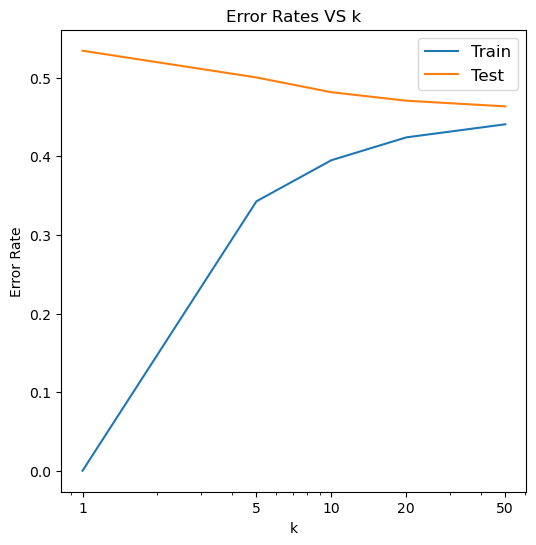

In [270]:
figure, axes = plt.subplots(1, figsize=(6, 6))
k_values = [1, 5, 10, 20, 50]

tr_error_rates = []
te_error_rates = []

diabetes_X_tr_arr = diabetes_X_tr.values
diabetes_y_tr_arr = diabetes_y_tr.values.ravel()
diabetes_X_te_arr = diabetes_X_te.values
diabetes_y_te_arr = diabetes_y_te.values.ravel()

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(diabetes_X_tr_arr, diabetes_y_tr_arr)
    tr_error_rates.append(1 - accuracy_score(diabetes_y_tr_arr, knn.predict(diabetes_X_tr_arr)))
    te_error_rates.append(1 - accuracy_score(diabetes_y_te_arr, knn.predict(diabetes_X_te_arr)))
axes.semilogx(k_values, tr_error_rates, label='Train')
axes.semilogx(k_values, te_error_rates, label='Test')
axes.set_xlabel('k')
axes.set_ylabel('Error Rate')
axes.set_title('Error Rates VS k')
axes.legend(fontsize=12)
axes.set_xticks(k_values)
axes.set_xticklabels(k_values)

plt.plot()

After Scaling:

[]

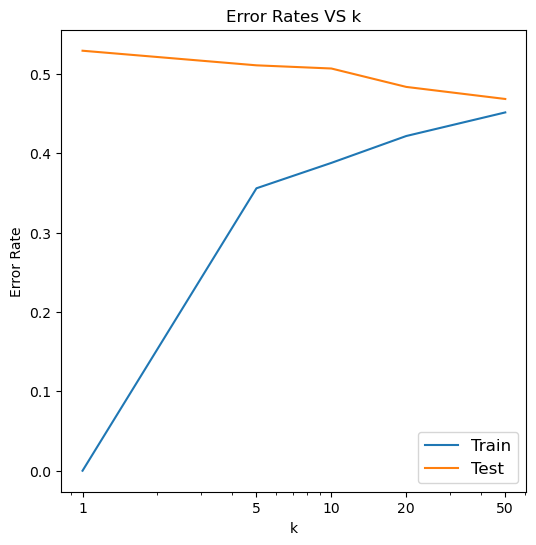

In [273]:
figure, axes = plt.subplots(1, figsize=(6, 6))

scaler = StandardScaler()

tr_error_rates = []
te_error_rates = []

diabetes_X_tr_arr = scaler.fit_transform(diabetes_X_tr.values)
diabetes_y_tr_arr = diabetes_y_tr.values.ravel()
diabetes_X_te_arr = scaler.fit_transform(diabetes_X_te.values)
diabetes_y_te_arr = diabetes_y_te.values.ravel()

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(diabetes_X_tr_arr, diabetes_y_tr_arr)
    tr_error_rates.append(1 - accuracy_score(diabetes_y_tr_arr, knn.predict(diabetes_X_tr_arr)))
    te_error_rates.append(1 - accuracy_score(diabetes_y_te_arr, knn.predict(diabetes_X_te_arr)))
axes.semilogx(k_values, tr_error_rates, label='Train')
axes.semilogx(k_values, te_error_rates, label='Test')
axes.set_xlabel('k')
axes.set_ylabel('Error Rate')
axes.set_title('Error Rates VS k')
axes.legend(fontsize=12)
axes.set_xticks(k_values)
axes.set_xticklabels(k_values)

plt.plot()

### Nearest Centroid